In [5]:
import os
import pandas as pd

root = "results"
model_name = "unet_conditional"
in_csv = os.path.join(root, f"{model_name}.csv")
df = pd.read_csv(in_csv)

# Define which columns to average
metrics = ["psnr_worst", "ssim_worst", "ocr_digit_acc", "ocr_plate_pass"]

# Group by model, alpha, beta and take the mean
agg_df = df.groupby(["model", "alpha", "beta"], as_index=False)[metrics].mean()

# Round for readability
agg_df["psnr_worst"] = agg_df["psnr_worst"].round(3)
agg_df["ssim_worst"] = agg_df["ssim_worst"].round(5)
agg_df["ocr_digit_acc"] = agg_df["ocr_digit_acc"].round(2)
agg_df["ocr_plate_pass"] = agg_df["ocr_plate_pass"].round(2)

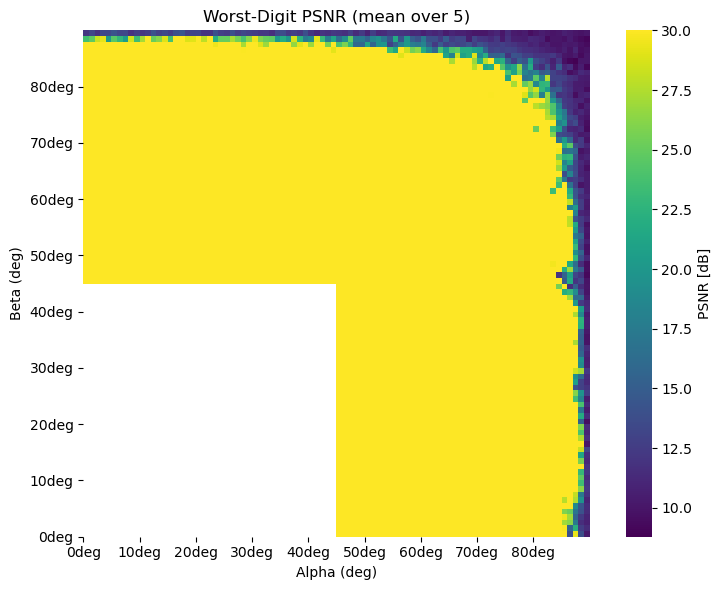

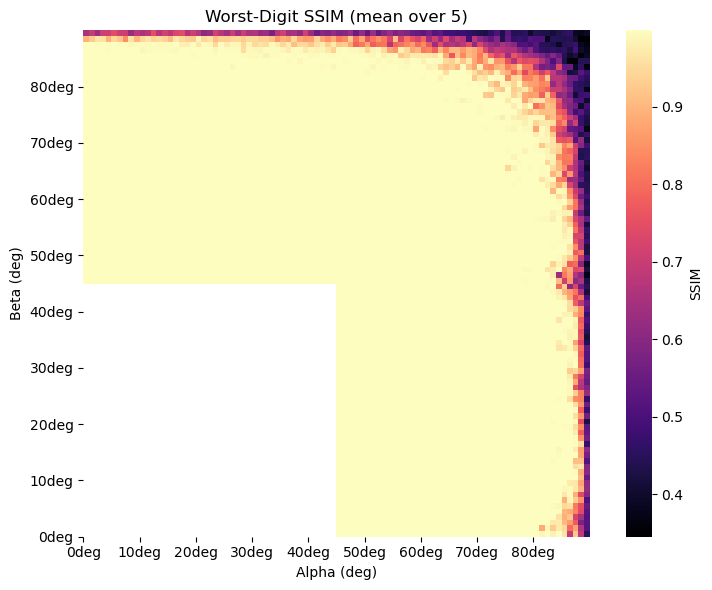

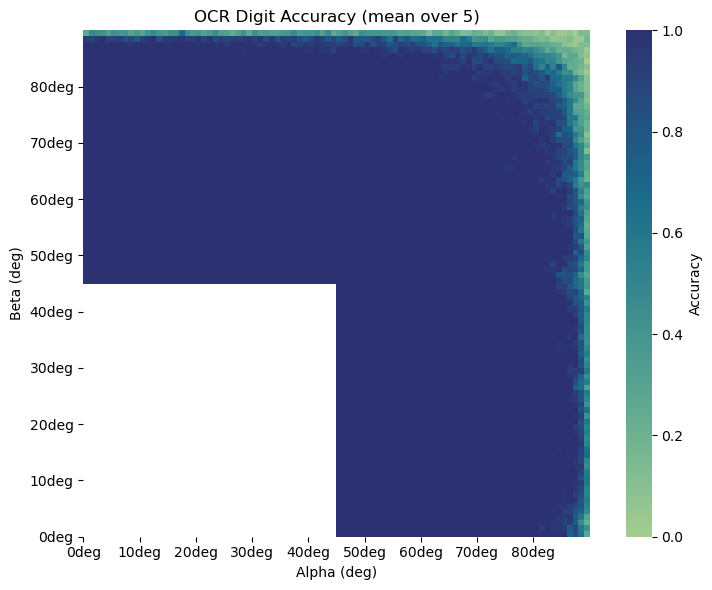

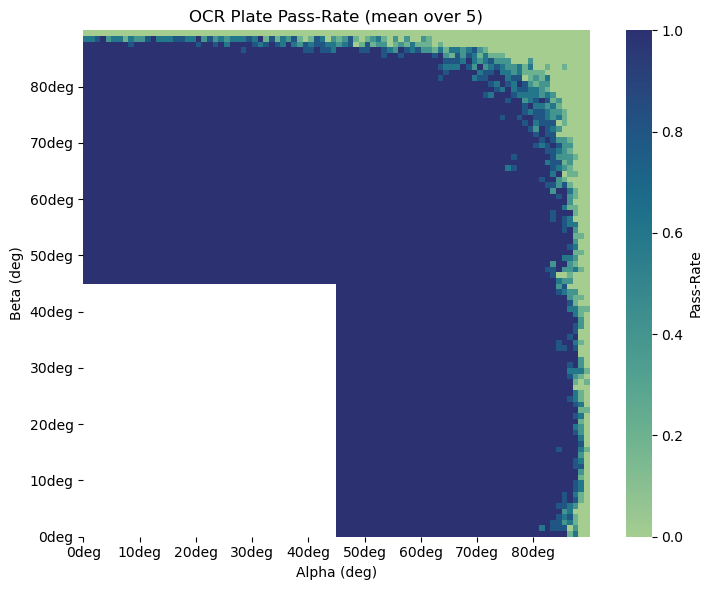

In [7]:
# ------------------------------------------------------------
# Build α×β matrices and draw one heat-map per metric
# ------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) get the distinct sorted angle axes
alpha_vals = np.sort(agg_df["alpha"].unique())
beta_vals = np.sort(agg_df["beta"].unique())


# 2) pivot helper
def metric_matrix(metric_name: str) -> np.ndarray:
    """Return a 2-D array shaped (len(beta) , len(alpha)) with NaN where data is missing."""
    pivot = (
        agg_df.pivot_table(index="beta", columns="alpha", values=metric_name)  # rows→β, cols→α
        .reindex(index=beta_vals, columns=alpha_vals)  # ensure full grid
        .to_numpy()
    )
    return pivot


psnr_mat = metric_matrix("psnr_worst")
ssim_mat = metric_matrix("ssim_worst")
acc_mat = metric_matrix("ocr_digit_acc")
bin_mat = metric_matrix("ocr_plate_pass")

# 1) Compute tick positions & labels at multiples of 10deg
alpha_ticks = [i for i, a in enumerate(alpha_vals) if a % 10 == 0]
beta_ticks = [i for i, b in enumerate(beta_vals) if b % 10 == 0]
alpha_labels = [f"{int(a)}deg" for a in alpha_vals if a % 10 == 0]
beta_labels = [f"{int(b)}deg" for b in beta_vals if b % 10 == 0]


# 2) General plotting function
def plot_heatmap(mat, title, cbar_label, clip_hi=None, cmap="viridis"):
    data = np.clip(mat, None, clip_hi) if clip_hi is not None else mat
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(
        data,
        cmap=cmap,
        cbar_kws={"label": cbar_label},
        square=True,  # square cells
        linewidths=0,  # no grid lines
        xticklabels=False,  # hide auto labels
        yticklabels=False,
    )
    # invert so β=0deg is at bottom
    ax.invert_yaxis()

    # set major ticks every 10deg
    ax.set_xticks(alpha_ticks)
    ax.set_xticklabels(alpha_labels, rotation=0)
    ax.set_yticks(beta_ticks)
    ax.set_yticklabels(beta_labels, rotation=0)

    ax.set_xlabel("Alpha (deg)")
    ax.set_ylabel("Beta (deg)")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


# 3) Plot each metric
plot_heatmap(psnr_mat, "Worst-Digit PSNR (mean over 5)", "PSNR [dB]", clip_hi=30)
plot_heatmap(ssim_mat, "Worst-Digit SSIM (mean over 5)", "SSIM", cmap="magma")
plot_heatmap(acc_mat, "OCR Digit Accuracy (mean over 5)", "Accuracy", clip_hi=1, cmap="crest")
plot_heatmap(bin_mat, "OCR Plate Pass-Rate (mean over 5)", "Pass-Rate", clip_hi=1, cmap="crest")

In [8]:
root = "results"
model_names = [
    "unet_base",
    "pix2pix",
    "restormer",
    "unet_conditional",
    "unet_residual",
    "diffusion",
]

# collect only the files
df_list = []
for m in model_names:
    path = os.path.join(root, f"{m}.csv")
    if os.path.isfile(path):
        df = pd.read_csv(path)
        df_list.append(df)
    else:
        print(f"  Skipping missing file: {path}")

# concatenate them all
df_all = pd.concat(df_list, ignore_index=True)

# aggregate
metrics = ["psnr_worst", "ssim_worst", "ocr_digit_acc", "ocr_plate_pass"]
agg_df = df_all.groupby(["model", "alpha", "beta"], as_index=False)[metrics].mean()

# round for readability
agg_df["psnr_worst"] = agg_df["psnr_worst"].round(3)
agg_df["ssim_worst"] = agg_df["ssim_worst"].round(5)
agg_df["ocr_digit_acc"] = agg_df["ocr_digit_acc"].round(2)
agg_df["ocr_plate_pass"] = agg_df["ocr_plate_pass"].round(2)

# save
out_path = os.path.join(root, "all_models_agg.csv")
agg_df.to_csv(out_path, index=False)
print(f"Aggregated metrics saved to {out_path} ({len(agg_df)} rows)")

Aggregated metrics saved to results\all_models_agg.csv (36450 rows)


In [9]:
# keep only high-distortion samples
roi_df = agg_df[(agg_df.alpha >= 80) | (agg_df.beta >= 80)].copy()

In [10]:
# 1) Compute metrics OVER the ROI
summary = roi_df.groupby("model", as_index=False).agg(
    psnr_mean=("psnr_worst", "mean"),
    ssim_mean=("ssim_worst", "mean"),
    ocr_acc_mean=("ocr_digit_acc", "mean"),
    plate_pass_pct=("ocr_plate_pass", "mean"),
    ocr_acc_std=("ocr_digit_acc", "std"),
    frac90=("ocr_digit_acc", lambda x: (x >= 0.9).mean()),
)

# 2) Add and normalize train/infer times
train_times = {
    "diffusion": 2.0 * 60,
    "restormer": 38.7,
    "pix2pix": 1.0 * 60,
    "unet_base": 28.7,
    "unet_residual": 29.2,
    "unet_conditional": 33.8,
}
inf_times = {
    "pix2pix": 2.80,
    "restormer": 7.95,
    "unet_base": 4.75,
    "unet_conditional": 7.30,
    "unet_residual": 4.43,
    "diffusion": 1330.00,
}
summary["train_time_min"] = summary["model"].map(train_times)
summary["inf_time_ms"] = summary["model"].map(inf_times)
fastest_train = summary["train_time_min"].min()
fastest_inf = summary["inf_time_ms"].min()
summary["train_time_norm"] = (summary["train_time_min"] / fastest_train).round(2)
summary["inf_time_norm"] = (summary["inf_time_ms"] / fastest_inf).round(2)

# 3) Round and reorder for presentation
for c in ["psnr_mean", "ssim_mean", "ocr_acc_mean", "plate_pass_pct", "ocr_acc_std", "frac90"]:
    summary[c] = summary[c].round(3)

cols = [
    "model",
    "psnr_mean",
    "ssim_mean",
    "ocr_acc_mean",
    "plate_pass_pct",
    "ocr_acc_std",
    "frac90",
    "train_time_norm",
    "inf_time_norm",
]
summary = summary[cols]

# 4) Save or print
#summary.to_csv("results/global_summary_roi.csv", index=False)
print(summary)

              model  psnr_mean  ssim_mean  ocr_acc_mean  plate_pass_pct  \
0         diffusion     12.631      0.529         0.771           0.492   
1           pix2pix     27.345      0.840         0.816           0.606   
2         restormer     36.121      0.868         0.845           0.648   
3         unet_base     32.596      0.858         0.840           0.646   
4  unet_conditional     32.091      0.866         0.841           0.651   
5     unet_residual     29.888      0.833         0.834           0.637   

   ocr_acc_std  frac90  train_time_norm  inf_time_norm  
0        0.272   0.516             4.18         475.00  
1        0.271   0.628             2.09           1.00  
2        0.248   0.681             1.35           2.84  
3        0.255   0.678             1.00           1.70  
4        0.255   0.682             1.18           2.61  
5        0.257   0.662             1.02           1.58  


In [6]:
# 1) Compute metrics OVER the ROI
summary = roi_df.groupby("model", as_index=False).agg(
    psnr_mean=("psnr_worst", "mean"),
    ssim_mean=("ssim_worst", "mean"),
    ocr_acc_mean=("ocr_digit_acc", "mean"),
    plate_pass_pct=("ocr_plate_pass", "mean"),
    ocr_acc_std=("ocr_digit_acc", "std"),
    frac90=("ocr_digit_acc", lambda x: (x >= 0.9).mean()),
)

# 2) Add and normalize train/infer times
train_times = {
    "diffusion": 2.0 * 60,
    "u_transformer": 38.7,
    "pix2pix": 1.0 * 60,
    "unet_base": 28.7,
    "unet_residual": 29.2,
    "unet_conditional": 33.8,
}
inf_times = {
    "pix2pix": 2.80,
    "u_transformer": 7.95,
    "unet_base": 4.75,
    "unet_conditional": 7.30,
    "unet_residual": 4.43,
    "diffusion": 1330.00,
}
summary["train_time_min"] = summary["model"].map(train_times)
summary["inf_time_ms"] = summary["model"].map(inf_times)
fastest_train = summary["train_time_min"].min()
fastest_inf = summary["inf_time_ms"].min()
summary["train_time_norm"] = (summary["train_time_min"] / fastest_train).round(2)
summary["inf_time_norm"] = (summary["inf_time_ms"] / fastest_inf).round(2)

# 3) Round and reorder for presentation
for c in ["psnr_mean", "ssim_mean", "ocr_acc_mean", "plate_pass_pct", "ocr_acc_std", "frac90"]:
    summary[c] = summary[c].round(3)

cols = [
    "model",
    "psnr_mean",
    "ssim_mean",
    "ocr_acc_mean",
    "plate_pass_pct",
    "ocr_acc_std",
    "frac90",
    "train_time_norm",
    "inf_time_norm",
]
summary = summary[cols]

# 4) Save or print
#summary.to_csv("results/global_summary_roi.csv", index=False)
print(summary)

              model  psnr_mean  ssim_mean  ocr_acc_mean  plate_pass_pct  \
0           pix2pix     24.069      0.826         0.825           0.592   
1     u_transformer     28.537      0.869         0.847           0.638   
2         unet_base     29.326      0.859         0.847           0.642   
3  unet_conditional     29.614      0.872         0.850           0.648   

   ocr_acc_std  frac90  train_time_norm  inf_time_norm  
0        0.252   0.631             2.09           1.00  
1        0.238   0.670             1.35           2.84  
2        0.241   0.681             1.00           1.70  
3        0.240   0.691             1.18           2.61  


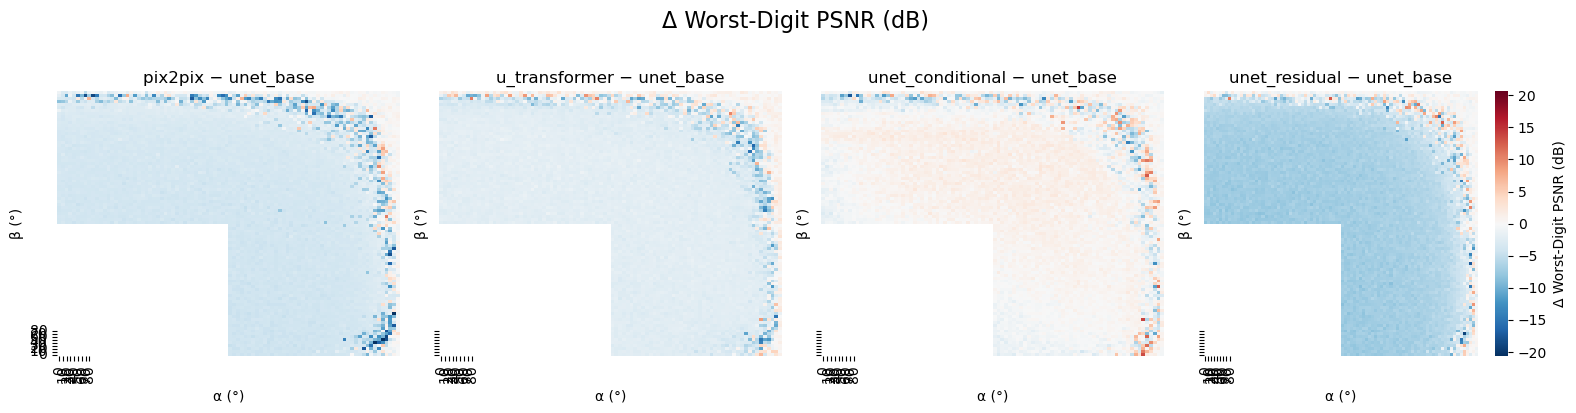

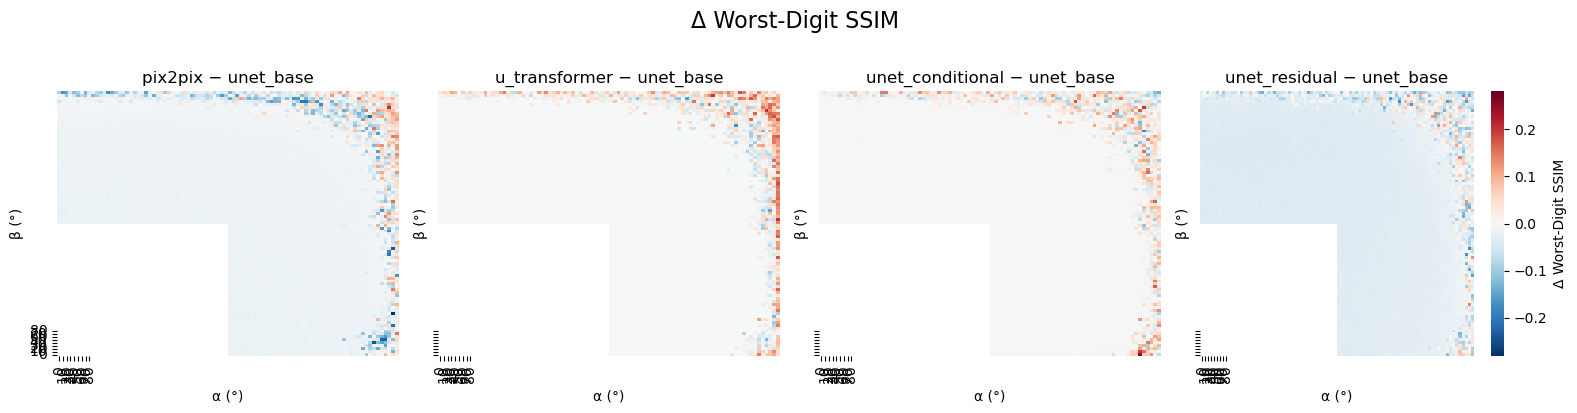

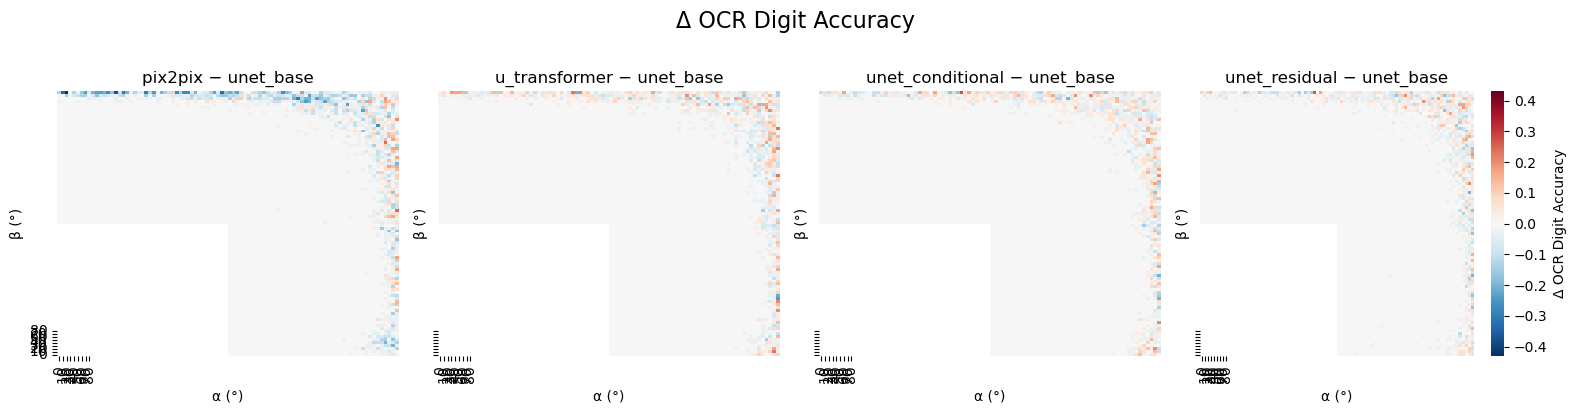

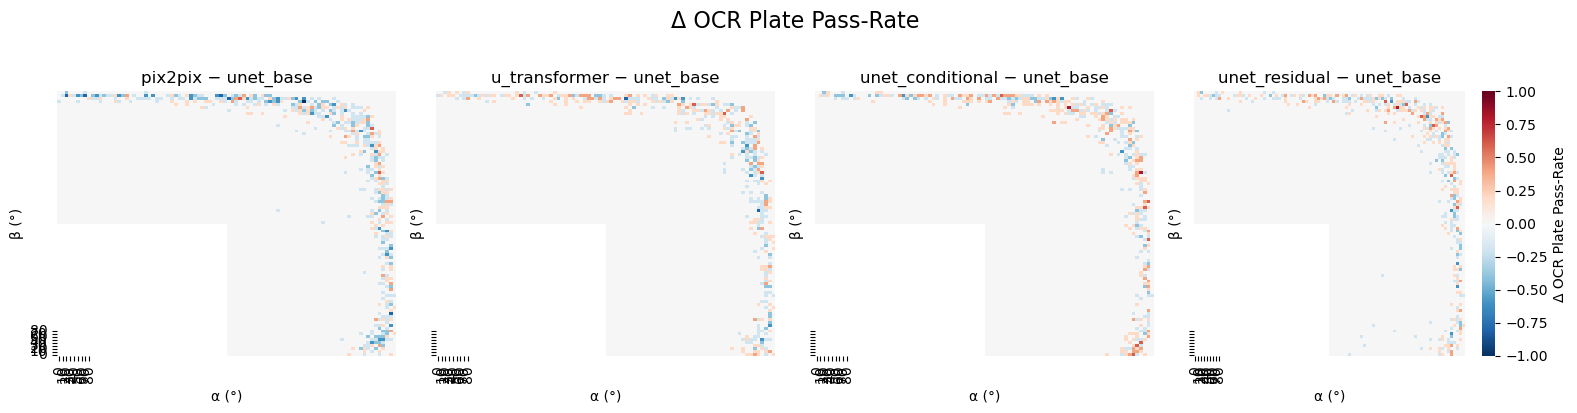

In [9]:
def pivot_matrix(df, metric, model_name):
    sub = df[df['model']==model_name]
    return (
      sub
      .pivot_table(index='beta', columns='alpha', values=metric)
      .reindex(index=beta_vals, columns=alpha_vals)
      .to_numpy()
    )

baseline = 'unet_base'
psnr_base = pivot_matrix(agg_df, 'psnr_worst', baseline)
ssim_base = pivot_matrix(agg_df, 'ssim_worst', baseline)
ocracc_base= pivot_matrix(agg_df, 'ocr_digit_acc', baseline)
plate_base = pivot_matrix(agg_df, 'ocr_plate_pass', baseline)


other_models = [m for m in agg_df['model'].unique() if m != baseline]

delta = {}
for m in other_models:
    delta.setdefault(m, {})
    delta[m]['psnr']      = pivot_matrix(agg_df, 'psnr_worst', m) - psnr_base
    delta[m]['ssim']      = pivot_matrix(agg_df, 'ssim_worst', m) - ssim_base
    delta[m]['ocr_acc']   = pivot_matrix(agg_df, 'ocr_digit_acc', m) - ocracc_base
    delta[m]['plate_pass']= pivot_matrix(agg_df, 'ocr_plate_pass', m) - plate_base



import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# choose a symmetric range for each metric
vmax = max(np.nanmax(np.abs(delta[m]['psnr'])) for m in other_models)
vmax_ssim = max(np.nanmax(np.abs(delta[m]['ssim'])) for m in other_models)
vmax_acc = max(np.nanmax(np.abs(delta[m]['ocr_acc'])) for m in other_models)
vmax_pass= max(np.nanmax(np.abs(delta[m]['plate_pass'])) for m in other_models)

def plot_delta_grid(metric_key, title, vmax):
    fig, axes = plt.subplots(
        nrows=1, ncols=len(other_models), figsize=(4*len(other_models), 4),
        sharex=True, sharey=True
    )
    for ax, m in zip(axes, other_models):
        mat = delta[m][metric_key]
        sns.heatmap(
            mat,
            ax=ax,
            cmap='RdBu_r',
            center=0,
            vmin=-vmax, vmax=vmax,
            xticklabels=alpha_ticks, yticklabels=beta_ticks,
            cbar=(ax==axes[-1]),  # single colorbar on last axis
            cbar_kws={'label': title}
        )
        ax.set_title(f"{m} − {baseline}")
        ax.invert_yaxis()
        ax.set_xlabel("α (°)")
        ax.set_ylabel("β (°)")
    fig.suptitle(title, fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# Now plot each metric
plot_delta_grid('psnr',       "Δ Worst‐Digit PSNR (dB)",      vmax)
plot_delta_grid('ssim',       "Δ Worst‐Digit SSIM",           vmax_ssim)
plot_delta_grid('ocr_acc',    "Δ OCR Digit Accuracy",        vmax_acc)
plot_delta_grid('plate_pass', "Δ OCR Plate Pass‐Rate",       vmax_pass)


###############################################################################################################################

In [ ]:
import os, json, cv2, math
from concurrent.futures import ThreadPoolExecutor, as_completed
from tesserocr import PyTessBaseAPI, OEM, PSM
from PIL import Image

# CONFIG 
TRAIN_DIR = r"C:\Users\stopc\Desktop\LPR_Project\data\val"
METADATA_PATH = os.path.join(TRAIN_DIR, "metadata.json")
N_WORKERS = 8

# LOAD METADATA 
with open(METADATA_PATH, "r") as f:
    records = json.load(f)


# WORKER FUNCTION 
def process_chunk(chunk):
    """
    OCR all plates in <chunk> (list of metadata dicts).
    Returns: (digit_ok, digit_total, plate_ok, plate_total, lines)
    """
    with PyTessBaseAPI(oem=OEM.LSTM_ONLY, psm=PSM.SINGLE_WORD) as api:
        api.SetVariable("tessedit_char_whitelist", "0123456789")
        api.SetVariable("load_system_dawg", "0")
        api.SetVariable("load_freq_dawg", "0")

        dig_ok = dig_tot = pl_ok = pl_tot = 0
        out_lines = []

        for rec in chunk:
            idx = rec["index"]
            truth = rec["plate_number"]
            img = cv2.imread(os.path.join(TRAIN_DIR, f"original_{idx}.png"))
            if img is None:
                out_lines.append(f"Plate {idx:4d} | [MISSING IMAGE]")
                continue

            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            _, bin_ = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)

            ocr_str = ""
            for i, (x, y, w, h) in enumerate(rec["digit_bboxes"]):

                patch = bin_[y : y + h, x : x + w]
                # convert NumPy array to PIL for tesserocr
                patch_pil = Image.fromarray(patch)
                api.SetImage(patch_pil)

                txt = api.GetUTF8Text().strip()
                digit = txt[0] if txt and txt[0].isdigit() else ""
                ocr_str += digit

                dig_tot += 1
                if digit == truth[i]:
                    dig_ok += 1

            if ocr_str == truth:
                pl_ok += 1
            pl_tot += 1

            status = "OK" if ocr_str == truth else "ERR"
            out_lines.append(f"Plate {idx:4d} | GT={truth} | OCR={ocr_str:<6} | {status}")

        return dig_ok, dig_tot, pl_ok, pl_tot, out_lines


# ── SPLIT WORK & RUN THREADS ──────────────────────────────────────────
chunk_size = math.ceil(len(records) / N_WORKERS)
chunks = [records[i : i + chunk_size] for i in range(0, len(records), chunk_size)]

digit_ok = digit_tot = plate_ok = plate_tot = 0
all_lines = []

with ThreadPoolExecutor(max_workers=N_WORKERS) as exe:
    futures = [exe.submit(process_chunk, c) for c in chunks]
    for fut in as_completed(futures):
        d_ok, d_tot, p_ok, p_tot, lines = fut.result()
        digit_ok += d_ok
        digit_tot += d_tot
        plate_ok += p_ok
        plate_tot += p_tot
        all_lines.extend(lines)

# ── PRINT DETAIL (comment out if too verbose) ─────────────────────────
for ln in sorted(all_lines):
    print(ln)

# ── SUMMARY ───────────────────────────────────────────────────────────
print("\nRESULTS")
print(f"  Digit-level accuracy: {digit_ok / digit_tot * 100:.2f}% " f"({digit_ok}/{digit_tot})")
print(f"  Plate-level accuracy: {plate_ok / plate_tot * 100:.2f}% " f"({plate_ok}/{plate_tot})")

Plate    0 | GT=688126 | OCR=688126 | OK
Plate    1 | GT=340319 | OCR=340319 | OK
Plate    2 | GT=012846 | OCR=012846 | OK
Plate    3 | GT=965515 | OCR=965515 | OK
Plate    4 | GT=492181 | OCR=492181 | OK
Plate    5 | GT=914514 | OCR=914514 | OK
Plate    6 | GT=056177 | OCR=056177 | OK
Plate    7 | GT=332430 | OCR=332430 | OK
Plate    8 | GT=060557 | OCR=060557 | OK
Plate    9 | GT=798237 | OCR=798237 | OK
Plate   10 | GT=759042 | OCR=759042 | OK
Plate   11 | GT=030998 | OCR=030998 | OK
Plate   12 | GT=845936 | OCR=845936 | OK
Plate   13 | GT=155139 | OCR=155139 | OK
Plate   14 | GT=060971 | OCR=060971 | OK
Plate   15 | GT=220941 | OCR=220941 | OK
Plate   16 | GT=410642 | OCR=410642 | OK
Plate   17 | GT=830474 | OCR=830474 | OK
Plate   18 | GT=189587 | OCR=189587 | OK
Plate   19 | GT=147466 | OCR=147466 | OK
Plate   20 | GT=487154 | OCR=487154 | OK
Plate   21 | GT=222176 | OCR=222176 | OK
Plate   22 | GT=571492 | OCR=571492 | OK
Plate   23 | GT=488530 | OCR=488530 | OK
Plate   24 | GT=

In [3]:
%matplotlib qt

In [6]:
%matplotlib inline

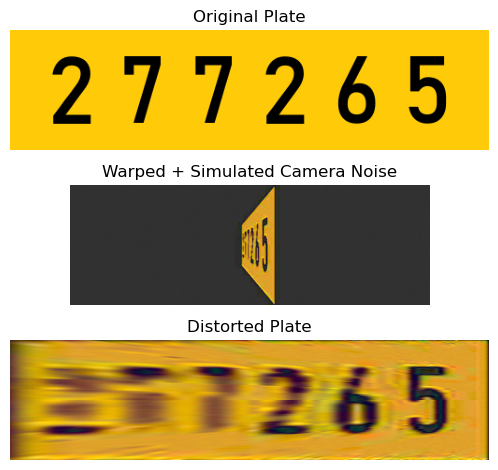

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scripts.lp_processing import (
    create_license_plate,
    warp_image,
    simulate_noise,
    dewarp_image,
    crop_to_original_size,
)

random.seed(100)
np.random.seed(100)

# --- Test parameters (now 256×64 plates) ---
alpha, beta = 84, 0
width, height = 512, 128
text_size = 100
focal_length = width  # matches production f=original_width

# 1. Create a clean plate (PIL image in RGB) and get its corners
plate_pil, src_points, plate_number, _ = create_license_plate(width, height, text_size)

# 2. PIL → NumPy (RGB)
plate_rgb = np.array(plate_pil)

# 3. Warp (expects RGB, returns RGB)
warped_rgb, dst_points = warp_image(plate_rgb, np.array(src_points), alpha, beta, focal_length)

# 4. Noise (expects RGB, returns RGB)
noisy_rgb = simulate_noise(warped_rgb)

# 5. Dewarp (expects RGB, returns RGB)
dewarped_rgb = dewarp_image(noisy_rgb, src_points, dst_points)

orig_crop   = crop_to_original_size(plate_rgb,   width, height)
dewarp_crop = crop_to_original_size(dewarped_rgb, width, height)

fig, axes = plt.subplots(3, 1)

axes[0].imshow(orig_crop)
axes[0].axis('off')
axes[0].set_title(f'Original Plate')

axes[1].imshow(noisy_rgb)
axes[1].axis('off')
axes[1].set_title('Warped + Simulated Camera Noise')

axes[2].imshow(dewarp_crop)
axes[2].axis('off')
axes[2].set_title(f'Distorted Plate')

plt.tight_layout()
plt.show()


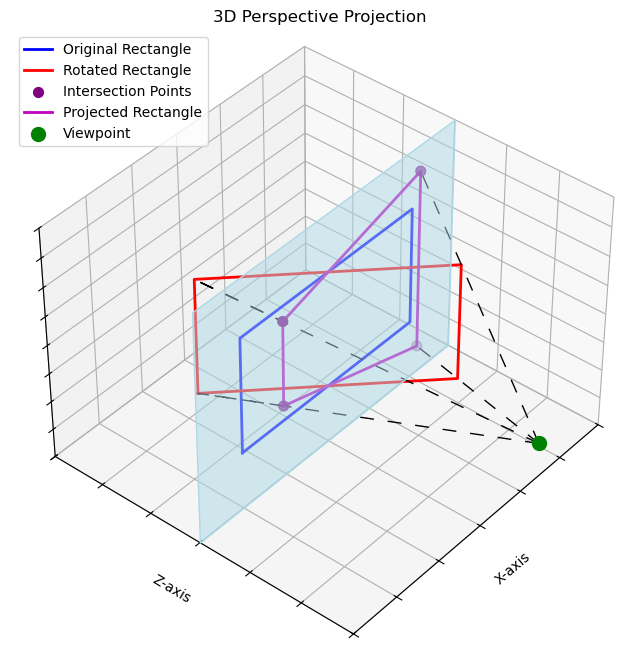

In [ ]:
# #Heatmap of worst PSNR, SSIM, and OCR in parallel
import os
import json
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
from tqdm import tqdm
import numpy as np
import mlflow
import mlflow.pytorch
import cv2
from pytorch_msssim import ssim
import pytesseract
from joblib import Parallel, delayed

# --------------------
# Configuration
# --------------------
data_dir = "data/full_grid"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# MLflow model load
mlflow.set_experiment("Unet")
client = mlflow.tracking.MlflowClient()
experiment = client.get_experiment_by_name("Unet")
runs = client.search_runs(
    experiment_ids=experiment.experiment_id, order_by=["attributes.start_time DESC"], max_results=1
)
run_id = runs[0].info.run_id
model_uri = f"runs:/{run_id}/model"
model = mlflow.pytorch.load_model(model_uri)
model.eval().to(device)
print(f"Model loaded from run {run_id} in experiment '{experiment.name}' successfully.")

# --------------------
# Functions
# --------------------


def calculate_psnr(outputs, targets):
    mse = F.mse_loss(outputs, targets)
    if mse == 0:
        return float("inf")
    psnr = 10 * torch.log10(1 / mse)
    return psnr.item()


def ocr_single_digit(image_bgr):
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY)
    config = r"--oem 1 --psm 10 -c tessedit_char_whitelist=0123456789"
    text = pytesseract.image_to_string(thresh, config=config).strip()
    if len(text) == 1 and text.isdigit():
        return text
    return "?"


def align_and_update_bboxes(original_np, generated_np, digit_bboxes):
    search_margin = 16

    def process_digit_bbox(bbox):
        x, y, w, h = bbox
        original_digit = original_np[y : y + h, x : x + w, :]
        original_digit_gray = cv2.cvtColor((original_digit * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Define search window
        search_x1 = max(0, x - search_margin)
        search_y1 = max(0, y - search_margin)
        search_x2 = min(generated_np.shape[1], x + w + search_margin)
        search_y2 = min(generated_np.shape[0], y + h + search_margin)
        search_region = generated_np[search_y1:search_y2, search_x1:search_x2, :]
        search_region_gray = cv2.cvtColor((search_region * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

        # Template matching
        result = cv2.matchTemplate(search_region_gray, original_digit_gray, cv2.TM_CCOEFF_NORMED)
        _, _, _, max_loc = cv2.minMaxLoc(result)
        best_x, best_y = max_loc[0] + search_x1, max_loc[1] + search_y1

        # Compute PSNR and SSIM
        aligned_digit = generated_np[best_y : best_y + h, best_x : best_x + w, :]
        original_digit_tensor = torch.from_numpy(original_digit.transpose(2, 0, 1)).unsqueeze(0)
        aligned_digit_tensor = torch.from_numpy(aligned_digit.transpose(2, 0, 1)).unsqueeze(0)

        psnr_val = calculate_psnr(aligned_digit_tensor, original_digit_tensor)
        ssim_val = ssim(aligned_digit_tensor, original_digit_tensor, data_range=1.0, size_average=True).item()

        return psnr_val, ssim_val, (best_x, best_y, w, h)

    results = Parallel(n_jobs=-1)(delayed(process_digit_bbox)(bbox) for bbox in digit_bboxes)
    psnr_values = [r[0] for r in results]
    ssim_values = [r[1] for r in results]
    updated_bboxes = [r[2] for r in results]

    return psnr_values, ssim_values, updated_bboxes


def compute_ocr_metrics(image_bgr, updated_bboxes, plate_number_gt, margin):
    def process_bbox(bbox):
        x, y, w, h = bbox
        x1 = max(0, x - margin)
        y1 = max(0, y - margin)
        x2 = min(image_bgr.shape[1], x + w + margin)
        y2 = min(image_bgr.shape[0], y + h + margin)
        digit_patch = image_bgr[y1:y2, x1:x2]
        recognized_digit = ocr_single_digit(digit_patch)
        return recognized_digit

    recognized_digits = Parallel(n_jobs=-1)(delayed(process_bbox)(bbox) for bbox in updated_bboxes)
    recognized_text = "".join(recognized_digits)
    gt = plate_number_gt
    correct_digits = sum(1 for a, b in zip(gt, recognized_text) if a == b)
    ocr_accuracy = correct_digits / len(gt) if len(gt) > 0 else 0.0
    ocr_binary = 1.0 if recognized_text == gt else 0.0
    return recognized_text, ocr_accuracy, ocr_binary


# --------------------------------------
# Compute metrics for each (alpha, beta)
# --------------------------------------
metadata_path = os.path.join(data_dir, "metadata.json")
with open(metadata_path, "r") as f:
    metadata_list = json.load(f)

psnr_dict_worst = {}
ssim_dict_worst = {}
ocr_acc_dict_avg = {}
ocr_bin_dict_avg = {}

to_tensor = transforms.ToTensor()

for metadata in tqdm(metadata_list, desc="Processing images", unit="plate"):
    alpha = metadata["alpha"]
    beta = metadata["beta"]
    digit_bboxes = metadata["digit_bboxes"]
    plate_number_gt = metadata["plate_number"]
    index = metadata["index"]

    index = metadata["index"]
    original_path = os.path.join(data_dir, f"original_{index}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{index}.png")

    if not (os.path.exists(original_path) and os.path.exists(distorted_path)):
        continue

    original_img = to_tensor(Image.open(original_path).convert("RGB")).unsqueeze(0).to(device)
    distorted_img = to_tensor(Image.open(distorted_path).convert("RGB")).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_img = model(distorted_img)
        generated_img = torch.clamp(generated_img, 0.0, 1.0)

    original_np = original_img.squeeze(0).permute(1, 2, 0).cpu().numpy()
    generated_np = generated_img.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Parallelized CPU operations
    psnr_per_number, ssim_per_number, updated_bboxes = align_and_update_bboxes(original_np, generated_np, digit_bboxes)
    image_bgr = (generated_np * 255).astype(np.uint8)
    image_bgr = cv2.cvtColor(image_bgr, cv2.COLOR_RGB2BGR)
    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(
        image_bgr, updated_bboxes, plate_number_gt, margin=2
    )

    # Take worst PSNR and SSIM
    worst_psnr = np.min(psnr_per_number) if psnr_per_number else 0.0
    worst_ssim = np.min(ssim_per_number) if ssim_per_number else 0.0

    if (alpha, beta) not in psnr_dict_worst:
        psnr_dict_worst[(alpha, beta)] = []
        ssim_dict_worst[(alpha, beta)] = []
        ocr_acc_dict_avg[(alpha, beta)] = []
        ocr_bin_dict_avg[(alpha, beta)] = []

    psnr_dict_worst[(alpha, beta)].append(worst_psnr)
    ssim_dict_worst[(alpha, beta)].append(worst_ssim)
    ocr_acc_dict_avg[(alpha, beta)].append(ocr_accuracy)
    ocr_bin_dict_avg[(alpha, beta)].append(ocr_binary)

alpha_values = sorted(set(a for (a, b) in psnr_dict_worst.keys()))
beta_values = sorted(set(b for (a, b) in psnr_dict_worst.keys()))
num_alphas, num_betas = len(alpha_values), len(beta_values)


def create_matrix_from_dict(data_dict):
    mat = np.full((num_betas, num_alphas), np.nan)
    alpha_to_index = {val: i for i, val in enumerate(alpha_values)}
    beta_to_index = {val: i for i, val in enumerate(beta_values)}
    for (a, b), val_list in data_dict.items():
        val = np.min(val_list) if val_list else np.nan
        mat[beta_to_index[b], alpha_to_index[a]] = val
    return mat


psnr_matrix = create_matrix_from_dict(psnr_dict_worst)
ssim_matrix = create_matrix_from_dict(ssim_dict_worst)
ocr_acc_matrix = create_matrix_from_dict(ocr_acc_dict_avg)
ocr_bin_matrix = create_matrix_from_dict(ocr_bin_dict_avg)

In [ ]:
def show_image_details_for(alpha, beta):
    # find the one record in metadata_list
    found = next((m for m in metadata_list if m["alpha"] == alpha and m["beta"] == beta), None)
    if found is None:
        print("No images found for that angle.")
        return

    # unpack everything from `found`
    index = found["index"]
    plate_number_gt = found["plate_number"]
    digit_bboxes = sorted(found["digit_bboxes"], key=lambda b: b[0])

    # file paths
    original_path = os.path.join(data_dir, f"original_{index}.png")
    distorted_path = os.path.join(data_dir, f"distorted_{index}.png")

    # load & run the model
    orig_t = to_tensor(Image.open(original_path).convert("RGB")).unsqueeze(0).to(device)
    dist_t = to_tensor(Image.open(distorted_path).convert("RGB")).unsqueeze(0).to(device)
    with torch.no_grad():
        gen_t = model(dist_t).clamp(0.0, 1.0)

    # to numpy
    orig_np = orig_t.squeeze(0).permute(1, 2, 0).cpu().numpy()
    gen_np = gen_t.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # compute per-digit PSNR/SSIM + updated bboxes
    psnr_vals, ssim_vals, updated_bboxes = align_and_update_bboxes(orig_np, gen_np, digit_bboxes)

    # load for display
    distorted_image_cv = cv2.imread(distorted_path)
    distorted_image_rgb = cv2.cvtColor(distorted_image_cv, cv2.COLOR_BGR2RGB)

    # Original image (with rectangles and text)
    original_image_cv = cv2.imread(original_path)
    for i, (x, y, w, h) in enumerate(digit_bboxes, start=1):
        cv2.rectangle(original_image_cv, (x, y), (x + w, y + h), (0, 0, 255), 1)
        cv2.putText(original_image_cv, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)
    original_image_rgb = cv2.cvtColor(original_image_cv, cv2.COLOR_BGR2RGB)

    # Generated image (with rectangles and text)
    generated_bgr = (gen_np * 255).astype(np.uint8)
    generated_bgr = cv2.cvtColor(generated_bgr, cv2.COLOR_RGB2BGR)
    generated_show = generated_bgr.copy()
    for i, (x, y, w, h) in enumerate(updated_bboxes, start=1):
        cv2.rectangle(generated_show, (x, y), (x + w, y + h), (0, 0, 255), 1)
        cv2.putText(generated_show, str(i), (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 150, 0), 1)
    generated_image_rgb = cv2.cvtColor(generated_show, cv2.COLOR_BGR2RGB)

    recognized_text, ocr_accuracy, ocr_binary = compute_ocr_metrics(
        generated_bgr, updated_bboxes, plate_number_gt, margin=2
    )

    # Prepare table
    table_data = [["Digit", "PSNR(dB)", "SSIM"]]
    for i, (p, s) in enumerate(zip(psnr_vals, ssim_vals), start=1):
        table_data.append([str(i), f"{p:.2f}", f"{s:.3f}"])
    transposed_table_data = list(zip(*table_data))

    # Plot in three rows
    fig2 = plt.figure(figsize=(11, 9))
    plt.subplot(3, 1, 1)
    plt.imshow(distorted_image_rgb)
    plt.title(f"Distorted (α={alpha}, β={beta})")
    plt.axis("off")
    plt.subplot(3, 1, 2)
    plt.imshow(original_image_rgb)
    plt.title("Original")
    plt.axis("off")
    plt.subplot(3, 1, 3)
    plt.imshow(generated_image_rgb)
    plt.title(
        f"Generated (GT={plate_number_gt}, Rec={recognized_text}, OCR Acc={ocr_accuracy*100:.1f}%, Bin={int(ocr_binary)})"
    )
    plt.axis("off")

    # Table underneath
    tbl = plt.table(cellText=transposed_table_data, cellLoc="center", loc="center", bbox=[0, -0.5, 1, 0.4])
    tbl.auto_set_font_size(False)
    tbl.set_fontsize(12)

    plt.tight_layout()
    plt.show()


def format_coord(x, y):
    col = int(round(x))
    row = int(round(y))
    if 0 <= row < num_betas and 0 <= col < num_alphas:
        alpha = alpha_values[col]
        beta = beta_values[row]
        psnr_value = psnr_matrix_clipped[row, col]
        return (
            f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: {psnr_value:.2f} dB"
            if not np.isnan(psnr_value)
            else f"Alpha: {alpha:.0f}, Beta: {beta:.0f}, PSNR: N/A"
        )
    return "Alpha: N/A, Beta: N/A"


psnr_matrix_clipped = np.clip(psnr_matrix, None, 20)

current_metric = "PSNR"
fig, ax = plt.subplots(figsize=(11, 9))
plt.subplots_adjust(bottom=0.15)  # space for buttons

# Draw initial heatmap
im = ax.imshow(psnr_matrix_clipped, origin="lower", aspect="auto", cmap="viridis")
ax.set_title("Worst PSNR per Image (Minimum Digit PSNR)")
cbar = plt.colorbar(im, ax=ax, label="PSNR (dB)")
ax.set_xticks(range(0, num_alphas, 5))
ax.set_xticklabels(alpha_values[::5])
ax.set_yticks(range(0, num_betas, 5))
ax.set_yticklabels(beta_values[::5])
ax.set_xlabel("Alpha (degrees)")
ax.set_ylabel("Beta (degrees)")
ax.format_coord = format_coord  # Set the coordinate display format

# Define button positions
button_width = 0.1  # Button width
button_height = 0.05  # Button height
button_spacing = 0.02  # Space between buttons

# Compute x-coordinates for buttons
x_start = 0.2  # Starting x-position
y_position = 0.03
x_psnr = x_start
x_ssim = x_psnr + button_width + button_spacing
x_ocr_acc = x_ssim + button_width + button_spacing
x_ocr_bin = x_ocr_acc + button_width + button_spacing

# Add buttons
ax_psnr = plt.axes([x_psnr, y_position, button_width, button_height])
ax_ssim = plt.axes([x_ssim, y_position, button_width, button_height])
ax_ocr_acc = plt.axes([x_ocr_acc, y_position, button_width, button_height])
ax_ocr_bin = plt.axes([x_ocr_bin, y_position, button_width, button_height])

btn_psnr = Button(ax_psnr, "PSNR")
btn_ssim = Button(ax_ssim, "SSIM")
btn_ocr_acc = Button(ax_ocr_acc, "OCR Acc")
btn_ocr_bin = Button(ax_ocr_bin, "OCR Bin")


def update_heatmap(metric):
    global current_metric
    current_metric = metric
    ax.clear()

    if metric == "PSNR":
        data = psnr_matrix_clipped
        title = "Worst PSNR per Image (Minimum Digit PSNR)"
        cbar_label = "PSNR (dB)"
    elif metric == "SSIM":
        data = ssim_matrix
        title = "Worst SSIM per Image (Minimum Digit SSIM)"
        cbar_label = "SSIM"
    elif metric == "OCR_Accuracy":
        data = ocr_acc_matrix
        title = "OCR Accuracy"
        cbar_label = "OCR Acc"
    else:
        data = ocr_bin_matrix
        title = "OCR Binary Accuracy (1=All Correct)"
        cbar_label = "OCR Binary"

    # Update heatmap
    im = ax.imshow(data, origin="lower", aspect="auto", cmap="viridis")
    ax.set_title(title)
    ax.set_xticks(range(0, num_alphas, 5))
    ax.set_xticklabels(alpha_values[::5])
    ax.set_yticks(range(0, num_betas, 5))
    ax.set_yticklabels(beta_values[::5])
    ax.set_xlabel("Alpha (degrees)")
    ax.set_ylabel("Beta (degrees)")

    # Update colorbar
    cbar.mappable = im
    cbar.set_label(cbar_label)
    cbar.update_normal(im)

    fig.canvas.draw_idle()


def on_psnr_clicked(event):
    update_heatmap("PSNR")


def on_ssim_clicked(event):
    update_heatmap("SSIM")


def on_ocr_acc_clicked(event):
    update_heatmap("OCR_Accuracy")


def on_ocr_bin_clicked(event):
    update_heatmap("OCR_Binary")


btn_psnr.on_clicked(on_psnr_clicked)
btn_ssim.on_clicked(on_ssim_clicked)
btn_ocr_acc.on_clicked(on_ocr_acc_clicked)
btn_ocr_bin.on_clicked(on_ocr_bin_clicked)


# Connect the click event after setting up the entire figure
def on_click(event):
    if event.inaxes == ax:  # Ensure the click is within the heatmap axis
        x, y = event.xdata, event.ydata
        if x is None or y is None:
            return
        col = int(round(x))
        row = int(round(y))
        if 0 <= row < num_betas and 0 <= col < num_alphas:
            alpha = alpha_values[col]
            beta = beta_values[row]
            show_image_details_for(alpha, beta)


cid = fig.canvas.mpl_connect("button_press_event", on_click)  # Connect after all setups

plt.show()